In [1]:
"""
This notebook was created using Jupyter Notebook on an iPython2.7 kernel with nbextensions to enable header toggling.

It is recommended to run this notebook under the same conditions for maximum compatibility.

"""

'\nThis notebook was created using Jupyter Notebook on an iPython2.7 kernel with nbextensions to enable header toggling.\n\nIt is recommended to run this notebook under the same conditions for maximum compatibility.\n\n'

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import cPickle as pkl
from itertools import izip, count
from copy import deepcopy

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
import seaborn as sns

In [3]:
labels = ['soma', 'apical', 'basal']
days = [0, 1, 2, 3]
timepoints = ['baseline', 'stim', '0h', '24h', '48h', '72h']
groups = ['WT', 'KO']
colors = [(0, 1, 0), (1, 0, 1)]
typeColors = {'soma':(0, 0, 0), 'basal':(0, 0, 1), 'apical':(0., .5, 0.)}
typeColormaps = {'soma':'Greys', 'basal':'Blues', 'apical':'Greens'}
dendTypes = ['apical', 'basal']
dendColors = [(0., .5, 0.), (0, 0, 1)]
alphaVals = [0.6, 1]

In [4]:
dataDir = '/home/justin/notebooks/Analysis/OHare2022/data' #update this based on where you clone the repo

# helper functions

In [5]:
def testNormality(data, interpX):
    data = data[~np.isnan(data)]
    loc, scale = stats.norm.fit(data)
    n = stats.norm(loc=loc, scale=scale)
    h, p = stats.kstest(data, n.cdf)
    return p

In [6]:
def printResults(labelData):
    
    norm = True
    for data in labelData.values():
        p_norm = testNormality(np.array(data), 100)
        if p_norm < 0.05:
            norm = False
            break
    
    if norm == False:
        stat, p = stats.mannwhitneyu(labelData.values()[0], labelData.values()[1])
        str_out = '{} med = {}, IQR = {}, n = {}; {} med = {}, IQR = {}, n = {}; mann whitney U = {}, p = {}'.format(
            labelData.keys()[0], np.nanmedian(labelData.values()[0]), stats.iqr(labelData.values()[0]), 
            np.sum(~np.isnan(labelData.values()[0])), labelData.keys()[1], np.nanmedian(labelData.values()[1]), 
            stats.iqr(labelData.values()[1]), np.sum(~np.isnan(labelData.values()[1])), stat, p)
    else:
        t, p = stats.ttest_ind(labelData.values()[0], labelData.values()[1], equal_var=False)
        str_out = '{} mean = {} +/- {}, n = {}; {} mean = {} +/- {}, n = {}; ttest t = {}, p = {}'.format(
            labelData.keys()[0], np.nanmean(labelData.values()[0]), stats.sem(labelData.values()[0]), 
            np.sum(~np.isnan(labelData.values()[0])), labelData.keys()[1], np.nanmean(labelData.values()[1]), 
            stats.sem(labelData.values()[1]), np.sum(~np.isnan(labelData.values()[1])), t, p)
    return str_out

In [7]:
def filterDF(df, cDict, inv=False, resetIndex=True):
    #filter pandas dataframe by dict of column names (keys) and values
    mask = np.zeros((df.shape[0], len(cDict.keys())))
    for idx, label, val in izip(count(), cDict.keys(), cDict.values()):

        if inv:
            if val is np.nan:
                mask[:, idx] = ~np.isnan(df[label])
            else:
                mask[:, idx] = (df[label] != val)

        else:
            if val is np.nan:
                if isinstance(df[label].iloc[0], (list, np.ndarray)):
                    mask[:, idx] = np.array([np.any(np.isnan(x)) for x in df[label]])
                else:
                    mask[:, idx] = np.isnan(df[label])
            else:
                if isinstance(df[label].iloc[0], (list, np.ndarray)):
                    mask[:, idx] = np.array([np.all(x == val) for x in df[label]])
                else:
                    mask[:, idx] = (df[label] == val)

    mask = np.all(mask, axis=1)
    df_out = df.loc[mask].copy(deep=True)

    if resetIndex:
        df_out.reset_index(inplace=True, drop=True)

    return df_out

In [8]:
from scipy.ndimage.filters import gaussian_filter1d
def smoothData(data, smoothLength=2, nan_norm=True, axis=1):

    if smoothLength == 0 or smoothLength is None:
        return data

    if len(data.shape) == 1:
        axis = 0

    mean_zeroed = np.nan_to_num(data)
    gaus_mean = gaussian_filter1d(mean_zeroed, smoothLength, mode='wrap', axis=axis)

    if nan_norm:
        isfinite = np.isfinite(data).astype(float)
        sm_isfinite = gaussian_filter1d(isfinite, smoothLength, mode='wrap', axis=axis)
        return gaus_mean / sm_isfinite
    else:
        return gaus_mean

In [9]:
def formatPlot(ax, offset=10, left=False, bottom=False, right=True, top=True):
    for axis in ['left', 'right', 'bottom', 'top']:
        ax.spines[axis].set_linewidth(1.5)
    ax.tick_params(labelsize=14)
    sns.despine(ax=ax, offset=offset, left=left, bottom=bottom, right=right, top=top)

In [10]:
#rough metric to plot/analyze PF locations; assumes PF symmetry 
def pfCenter(pfBounds): 
    
    if pfBounds[1] < pfBounds[0]:
        center = np.mean([pfBounds[0], pfBounds[1] + 1])
        if center > 1:
            center -= 1
    else:
        center = np.mean(pfBounds)
        
    return center

In [11]:
def circDist(a, b, minVal, maxVal):

    assert np.min([a, b]) >= minVal and np.max([a, b]) <= maxVal

    d1 = np.abs(a - b)
    d2 = (np.min([a, b]) - minVal) + (maxVal - np.max([a, b]))
    dist = np.min([d1, d2])

    return dist

# Figure 2

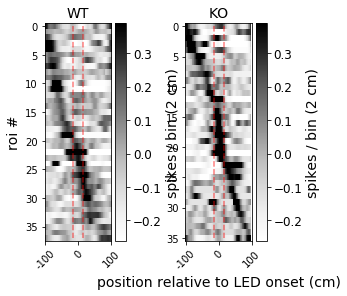

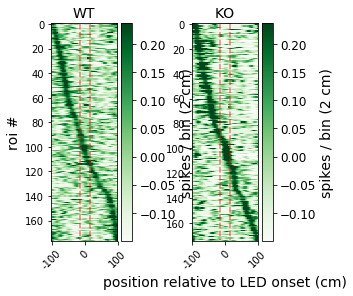

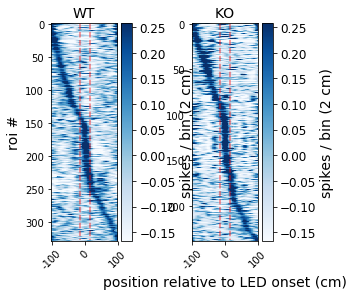

In [12]:
#2A
filePath = os.path.join(dataDir, 'single_cell', 'centeredTCs_spikes.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
for label in labels:
    fig, axes = plt.subplots(1, 2, figsize=(4, 4), sharex=True, sharey=False)
    plt.subplots_adjust(wspace=0.7)
    cmap = typeColormaps[label]
    groupTCs = np.vstack(filterDF(df, {'label':label}).tc)
    clim = [np.nanpercentile(groupTCs, 5), np.nanpercentile(groupTCs, 95)]
    for group, ax in zip(groups, axes):
        currDF = filterDF(df, {'group':group, 'label':label})
        tcs = np.vstack(currDF.tc[np.argsort(currDF.center)])
        cbmap = ax.imshow(tcs, cmap=cmap, clim=clim, aspect='auto')
        ax.vlines([42.5, 57.5], 0, tcs.shape[0] - 1, colors=['r', 'r'], linestyles=['--', '--'], alpha=0.5)
        ax.set_title(group, fontsize=14)
        ax.set_xticks([0, 50, 100])
        ax.set_xticklabels(['-100', '0', '100'], rotation=45)
        
        cb = fig.colorbar(cbmap, ax=ax)
        cb.set_label('spikes / bin (2 cm)', fontsize=14)
        cb.ax.tick_params(labelsize=12)
    axes[1].set_xlabel('position relative to LED onset (cm)', fontsize=14)
    axes[0].set_ylabel('roi #', fontsize=14)

del df

0.14285714285714285
0.14285714285714285
0.11607142857142853
0.15441176470588236
0.10389610389610394
0.1261682242990654


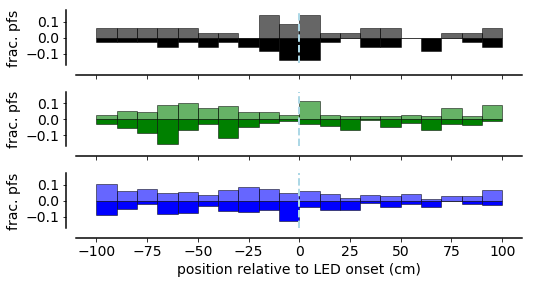

In [13]:
#2B
filePath = os.path.join(dataDir, 'single_cell', 'pfsNearLED_allDays_allPFs.pkl')
#despite filename saying 'nearLED', 'allDays' overrides requirements and includes all PFs here

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
nBins = 20
alignTo = 0.5
edgeColor = (0, 0, 0, .5)
trackLength = 200
invert = [False, True]
    
fig, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.5)
histRange = np.multiply([-0.5, .5], trackLength)
for ax, label in zip(axes, labels):
    rgb = to_rgb(typeColors[label])
    for group, alpha, inv in zip(groups, alphaVals, invert):
        rgba = (rgb[0], rgb[1], rgb[2], alpha)
        currDF = filterDF(df, {'group':group, 'label':label})
        alignedCenters = []
        for pfs, led in zip(currDF.pfBounds, currDF.ledOnset):
            center = pfCenter(pfs[0])
            offset = led - alignTo
            center -= offset
            if center < 0:
                center += 1
            elif center > 1:
                center -= 1
            alignedCenters.append((center - 0.5) * trackLength)
        weights = np.tile(1. / len(alignedCenters), len(alignedCenters))
        hist, edges = np.histogram(alignedCenters, bins=nBins, range=histRange, weights=weights)
        print(np.max(hist))
        if inv:
            hist *= -1
        binCenters = 0.5 * (edges + np.roll(edges, -1))[:-1]
        ax.bar(binCenters, height=hist, width=np.diff(edges), color=rgba, 
               edgecolor=edgeColor, linewidth=1, label=group)
    ylims = ax.get_ylim()
    ax.vlines(0, ylims[0], ylims[1], color='lightblue', linestyle='--', linewidth=2)
    ax.set_ylabel('frac. pfs', fontsize=14)
    ax.set_ylim([-.17, .17])
    formatPlot(ax)
ax.set_xlabel('position relative to LED onset (cm)', fontsize=14)

del df

0.026000000000000023
0.249
soma: WT med = 0.879, IQR = 0.53075, n = 38; KO med = 0.9265, IQR = 0.362, n = 36; mann whitney U = 634.0, p = 0.294623359057
0.123
0.19799999999999995
apical: WT mean = 0.4742 +/- 0.0128899854204, n = 175; KO mean = 0.578560240964 +/- 0.0178568287873, n = 166; ttest t = -4.7386662162, p = 3.31005002492e-06
0.16100000000000003
0.15500000000000003
basal: WT med = 0.575, IQR = 0.342, n = 329; KO med = 0.603, IQR = 0.386, n = 239; mann whitney U = 35630.0, p = 0.0281675953681


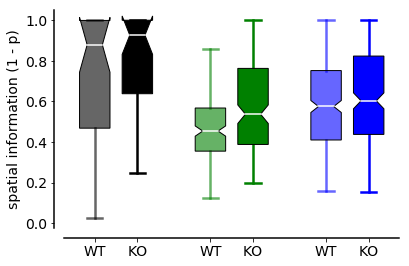

In [14]:
#2C
filePath = os.path.join(dataDir, 'single_cell', 'spatialInfo.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
fig, ax = plt.subplots(figsize=(6, 4))

excludeVal = 0

datasets = []
boxColors = []
dataLabels = []
positions = []
x = 1
for label in labels:
    rgb = to_rgb(typeColors[label])
    groupVals = {}
    for group, alpha in zip(groups, alphaVals):
        rgba = (rgb[0], rgb[1], rgb[2], alpha)
        currData = filterDF(df, {'type':label, 'group':group}).pVal
        spatialInfo = np.array([1 - p for p in currData])
        print(np.min(spatialInfo))
        datasets.append(spatialInfo)
        boxColors.append(rgba)
        dataLabels.append(group)
        positions.append(x)
        groupVals[group] = spatialInfo
        x += .7
    x += .5
    print('{}: {}'.format(label, printResults(groupVals)))
    
bp = ax.boxplot(datasets, positions=positions, labels=dataLabels, 
                showfliers=False, widths=0.5, patch_artist=True, notch=True)
for box, color in zip(bp['medians'], boxColors):
    box.set(color='w', lw=1.5)
for box, color in zip(bp['boxes'], boxColors):
    box.set_facecolor(color=color)
for element in ['whiskers', 'caps']:
    colorDex = 0
    for boxDex, box in enumerate(bp[element]):
        box.set(color=boxColors[colorDex], lw=2.5)
        if np.remainder(boxDex + 1, 2) == 0 and boxDex != 0:
            colorDex += 1
formatPlot(ax)
ax.set_ylabel('spatial information (1 - p)', fontsize=14)

del df

soma: WT mean = 0.490525111982 +/- 0.0286056394888, n = 35; KO mean = 0.537179906879 +/- 0.0293221707666, n = 35; ttest t = -1.13891404612, p = 0.258737842758
apical: WT mean = 0.437307503207 +/- 0.0153196605157, n = 112; KO mean = 0.457811476334 +/- 0.0156654027024, n = 136; ttest t = -0.935779657839, p = 0.350309595902
basal: WT mean = 0.431369406578 +/- 0.0103778191497, n = 231; KO mean = 0.46853103527 +/- 0.0115182190216, n = 214; ttest t = -2.39693337874, p = 0.0169547717412


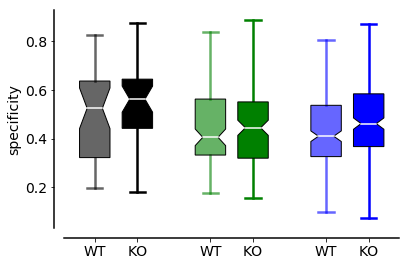

In [18]:
#2D-E (change variable at line 7 to toggle between)
filePath = os.path.join(dataDir, 'single_cell', 'pfsNearLED_allDays_allPFs.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
variable = 'specificity' # ['specificity', 'sensitivity']
inducedOnly = False
fig, ax = plt.subplots(figsize=(6, 4))

datasets = []
boxColors = []
dataLabels = []
positions = []
x = 1
for label in labels:
    rgb = to_rgb(typeColors[label])
    groupVals = {}
    for group, alpha in zip(groups, alphaVals):
        
        filterDict = {'label':label, 'group':group}
        if inducedOnly:
            filterDict['induced'] = True
                
        rgba = (rgb[0], rgb[1], rgb[2], alpha)
        currData = filterDF(df, filterDict)[variable]
        datasets.append(currData)
        boxColors.append(rgba)
        groupVals[group] = currData
        dataLabels.append(group)
        positions.append(x)
        x += .7
    x += .5
    
    print('{}: {}'.format(label, printResults(groupVals)))

bp = ax.boxplot(datasets, positions=positions, labels=dataLabels, 
                showfliers=False, widths=0.5, patch_artist=True, notch=True)
for box, color in zip(bp['medians'], boxColors):
    box.set(color='w', lw=1.5)
for box, color in zip(bp['boxes'], boxColors):
    box.set_facecolor(color=color)
for element in ['whiskers', 'caps']:
    colorDex = 0
    for boxDex, box in enumerate(bp[element]):
        box.set(color=boxColors[colorDex], lw=2.5)
        if np.remainder(boxDex + 1, 2) == 0 and boxDex != 0:
            colorDex += 1
formatPlot(ax)
ax.set_ylabel(variable, fontsize=14)

del df

# Figure 3

apical: WT mean = 0.172220450759 +/- 0.0290571092402, n = 164; KO mean = 0.382200372703 +/- 0.0476096615696, n = 88; ttest t = -3.76468011799, p = 0.000237459688169
basal: WT med = 0.528300901676, IQR = 0.496499355605, n = 105; KO med = 0.6759467281, IQR = 0.471744163711, n = 121; mann whitney U = 5433.0, p = 0.0304247012145


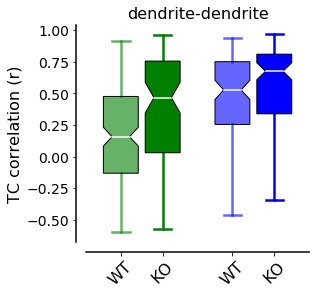

In [19]:
#3B 
filePath = os.path.join(dataDir, 'single_cell', 'treeHeatmaps_spikes_activeOnly.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
smoothLength = 3

fig, ax = plt.subplots(1, figsize=(4, 4), sharey=True)

datasets = []
boxColors = []
dataLabels = []
positions = []
x = 1
for dendType, color in zip(dendTypes, dendColors):
    rgb = to_rgb(color)   
    corrsByGroup = {}
    for group, alpha in zip(groups, alphaVals):
        rgba = (rgb[0], rgb[1], rgb[2], alpha)
        currData = []
        corrsByGroup[group] = []
        for day in days:
            currDF = filterDF(df, {'group':group, 'day':day})
            for idx, cell in currDF.iterrows():
                treeDF = cell.treeDF
                dendDF = filterDF(treeDF, {'type':dendType})

                if not len(dendDF):
                    continue

                cellCorrs = []
                for idx, dend in dendDF.iterrows():

                    if day == 0:
                        lapInds = np.arange(10, dend.heatmap.shape[0])
                    else:
                        lapInds = np.arange(dend.heatmap.shape[0])

                    parentID = dend.id[:-2]
                    parents = filterDF(dendDF, {'id':parentID})
                    for idx, parent in parents.iterrows(): 
                        parentTC = smoothData(np.nanmean(parent.heatmap[lapInds, :], axis=0), smoothLength=smoothLength)
                        childTC = smoothData(np.nanmean(dend.heatmap[lapInds, :], axis=0), smoothLength=smoothLength)
                        r, _ = stats.pearsonr(childTC, parentTC)
                        currData.append(r)
                        cellCorrs.append(r)
                        
                corrsByGroup[group].extend(cellCorrs)

        datasets.append(currData)
        positions.append(x)
        boxColors.append(rgba)
        dataLabels.append(group)
        x += .6
    x += .4
    
    print('{}: {}'.format(dendType, printResults(corrsByGroup)))
               
bp = ax.boxplot(datasets, positions=positions, labels=dataLabels, 
                showfliers=False, widths=0.5, patch_artist=True, notch=True)
for box, color in zip(bp['medians'], boxColors):
    box.set(color='w', lw=1.5)
for box, color in zip(bp['boxes'], boxColors):
    box.set_facecolor(color=color)
for element in ['whiskers', 'caps']:
    colorDex = 0
    for boxDex, box in enumerate(bp[element]):
        box.set(color=boxColors[colorDex], lw=2.5)
        if np.remainder(boxDex + 1, 2) == 0 and boxDex != 0:
            colorDex += 1
    
ax.set_title('dendrite-dendrite', fontsize=16)
ax.set_ylabel('TC correlation (r)'.format(dendType), fontsize=16)
formatPlot(ax)
ax.set_xticklabels(dataLabels, fontsize=16, rotation=45)
    
del df

apical: WT mean = 0.102541296849 +/- 0.0303645513167, n = 175; KO mean = 0.348924870041 +/- 0.0302536499161, n = 166; ttest t = -5.74808226803, p = 2.01405003973e-08
basal: WT med = 0.58912958127, IQR = 0.520288060736, n = 329; KO med = 0.54636092805, IQR = 0.436449805941, n = 239; mann whitney U = 38097.0, p = 0.264088883925


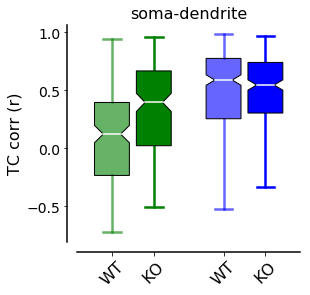

In [20]:
#3C
filePath = os.path.join(dataDir, 'single_cell', 'treeHeatmaps_spikes_activeOnly.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
smoothLength = 3

fig, ax = plt.subplots(1, figsize=(4, 4), sharey=True)

datasets = []
boxColors = []
dataLabels = []
positions = []
x = 1
for dendType, color in zip(dendTypes, dendColors):
    rgb = to_rgb(color)    
    corrsByGroup = {}
    for group, alpha in zip(groups, alphaVals):
        rgba = (rgb[0], rgb[1], rgb[2], alpha)
        corrsByGroup[group] = []
        currData = []
        for day in days:
            currDF = filterDF(df, {'group':group, 'day':day})
            for idx, cell in currDF.iterrows():
                treeDF = cell.treeDF
                somaDF = filterDF(treeDF, {'type':'soma'})
                somaPFs = treeDF.pfBounds

                dendDF = filterDF(treeDF, {'type':dendType})
                somaHeatmap = somaDF.heatmap[0]

                if day == 0:
                    lapInds = np.arange(10, somaHeatmap.shape[0])
                else:
                    lapInds = np.arange(somaHeatmap.shape[0])

                somaTC = smoothData(np.nanmean(somaHeatmap[lapInds, :], axis=0), smoothLength=smoothLength)

                cellCorrs = []
                for idx, dend in dendDF.iterrows():

                    dendTC = smoothData(np.nanmean(dend.heatmap[lapInds, :], axis=0), smoothLength=smoothLength)
                    r, _ = stats.pearsonr(somaTC, dendTC)
                    currData.append(r)
                    cellCorrs.append(r)
                corrsByGroup[group].extend(cellCorrs)
                    
        positions.append(x)
        boxColors.append(rgba)
        dataLabels.append(group)
        datasets.append(currData)
        x += .6
    x += .4
    
    print('{}: {}'.format(dendType, printResults(corrsByGroup)))
    
bp = ax.boxplot(datasets, positions=positions, labels=dataLabels, 
                showfliers=False, widths=0.5, patch_artist=True, notch=True)
for box, color in zip(bp['medians'], boxColors):
    box.set(color='w', lw=1.5)
for box, color in zip(bp['boxes'], boxColors):
    box.set_facecolor(color=color)
for element in ['whiskers', 'caps']:
    colorDex = 0
    for boxDex, box in enumerate(bp[element]):
        box.set(color=boxColors[colorDex], lw=2.5)
        if np.remainder(boxDex + 1, 2) == 0 and boxDex != 0:
            colorDex += 1
            
ax.set_title('soma-dendrite', fontsize=16)
ax.set_ylabel('TC corr (r)', fontsize=16)
formatPlot(ax)
ax.set_xticklabels(dataLabels, fontsize=16, rotation=45)

del df, currDF

apical WT: 145 dendrites from 15 cell-sessions
apical KO: 164 dendrites from 27 cell-sessions
apical: WT med = 47.0, IQR = 48.0, n = 145; KO med = 22.0, IQR = 53.75, n = 164; mann whitney U = 9242.0, p = 0.000364743006223
basal WT: 318 dendrites from 19 cell-sessions
basal KO: 302 dendrites from 25 cell-sessions
basal: WT med = 19.0, IQR = 47.0, n = 318; KO med = 18.0, IQR = 39.0, n = 302; mann whitney U = 47120.5, p = 0.343667011201


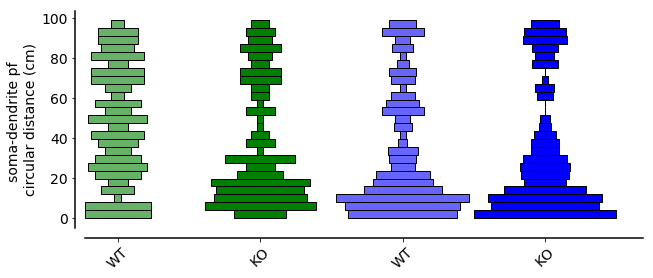

In [21]:
#3D. This code filters for dendrites that are place dendrites belonging to place cells
filePath = os.path.join(dataDir, 'single_cell', 'treeHeatmaps_spikes_activeOnly.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
nPosBins = 100
trackLength = 200. #cm

###make circDist dataframe
circDists = []
for dendType, color in zip(dendTypes, dendColors):
    for group, alphaVal in zip(groups, alphaVals):
        currDF = filterDF(df, {'group':group})
        for idx, cell in currDF.iterrows():
            somaPFs = cell.treeDF.pfBounds.values[0]

            if len(somaPFs):
                somaCenter = pfCenter(somaPFs[0])
            else:
                continue

            dendDF = filterDF(cell.treeDF, {'type':dendType})            
            for idx, dend in dendDF.iterrows():
                for dendPF in dend.pfBounds:
                    currDist = circDist(somaCenter, pfCenter(dendPF), 0, nPosBins) * (trackLength / nPosBins)
                    circDists.append({'group':group, 'dendType':dendType, 'circDist':currDist, 
                                     'pathLength':dend.distToSoma, 'order':dend.order, 
                                      'somaID':cell.somaID, 'day':cell.day})
circDists = pd.DataFrame(circDists)
del df, currDF, dendDF

###plot circ dists between PF centroids 
nBins = 25

histRange = [np.min(circDists.circDist), np.max(circDists.circDist)]
hists = []
histColors = []
xticklabels = []
alphas = []
for dendDex, dendType in enumerate(dendTypes):
    dendVals = {}
    for group, alpha in zip(groups, alphaVals):
        currDF = filterDF(circDists, {'dendType':dendType, 'group':group})
        currDists = currDF.circDist.to_numpy()
        hists.append(np.histogram(currDists, range=histRange, bins=nBins, density=True)[0])
        histColors.append(dendColors[dendDex])
        xticklabels.append(group)
        alphas.append(alpha)
        dendVals[group] = currDists
        cell_days = set([(somaID, day) for somaID, day in zip(currDF.somaID, currDF.day)])
        print('{} {}: {} dendrites from {} cell-sessions'.format(dendType, group, len(currDists), len(cell_days)))
    print('{}: {}'.format(dendType, printResults(dendVals)))
        
maxVals = np.max(hists, axis=1)
xx = np.arange(0, np.max(maxVals) * len(hists), np.max(maxVals))
binEdges = np.linspace(histRange[0], histRange[1], nBins + 1)
centers = 0.5 * (binEdges + np.roll(binEdges, -1))[:-1]
heights = np.diff(binEdges)

fig, ax = plt.subplots(figsize=(10, 4))
for x, hist, color, alpha in zip(xx, hists, histColors, alphas):
    lefts = x - 0.5 * hist
    rgba = (color[0], color[1], color[2], alpha)
    ax.barh(centers, hist, color=rgba, height=heights, left=lefts, edgecolor='k')

formatPlot(ax)
ax.set_xticks(xx)
ax.set_xticklabels(xticklabels, fontsize=14, rotation=45)
ax.set_ylabel('soma-dendrite pf \ncircular distance (cm)', fontsize=14)

del currDF

apical WT, n = 145
apical KO, n = 164
basal WT, n = 318
basal KO, n = 302
apical WT, n = 145
apical KO, n = 164


/home/justin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/justin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/justin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/justin/.local/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


basal WT, n = 318
basal KO, n = 302


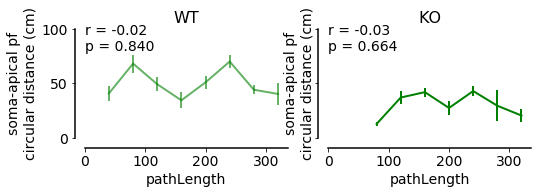

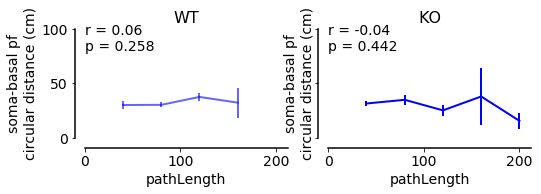

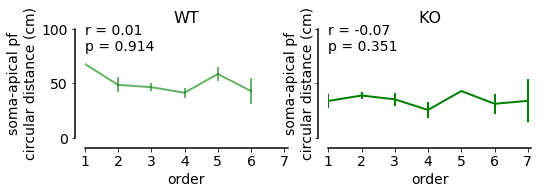

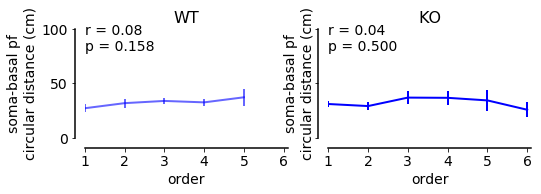

In [22]:
#3E
def myround(x, base):
    return base * np.ceil(float(x)/base)

regressors = ['pathLength', 'order']

for reg in regressors:
    for dendType, color in zip(dendTypes, dendColors):
        fig, axes = plt.subplots(1, 2, figsize=(8, 2), sharey=True)
        typeVals = filterDF(circDists, {'dendType':dendType})[reg]
        xRange = [np.min(typeVals), np.max(typeVals)]
        for ax, group, alpha in zip(axes, groups, alphaVals):
            currDF = filterDF(circDists, {'group':group, 'dendType':dendType})
            rgba = (color[0], color[1], color[2], alpha)
            if reg == 'pathLength':
                step = 40
                xVals = [int(myround(x, step)) for x in currDF[reg]]
                xticks = np.arange(0, xRange[1], 100)
                bins = np.arange(myround(xRange[0], step), myround(xRange[1], step), step)
            elif reg == 'order':
                xVals = currDF[reg]
                step = 1
                xticks = np.arange(1, xRange[1] + 1)
                bins = np.unique(currDF[reg])
            
            r, p = stats.pearsonr(currDF[reg], currDF.circDist)
            inds = np.digitize(xVals, bins)
            meanVals = [np.nanmean(currDF.circDist[inds == i]) for i in np.arange(1, len(bins) + 1)]
            yerr = [stats.sem(currDF.circDist[inds == i], nan_policy='omit') for i in np.arange(1, len(bins) + 1)]
            ax.errorbar(bins, meanVals, yerr, color=rgba, lw=2)
            print('{} {}, n = {}'.format(dendType, group, len(currDF)))
                            
            ax.set_xlim([xRange[0], xRange[1] + .1])
            ax.set_xticks(xticks)
            ax.set_ylim([0, 100])
            ax.set_title(group, fontsize=16)
            ax.set_ylabel('soma-{} pf\ncircular distance (cm)'.format(dendType), fontsize=14)
            ax.set_xlabel(reg, fontsize=14)
            ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * .8, 'r = {:.2f} \np = {:.3f}'.format(r, p), fontsize=14)
            formatPlot(ax)
            
del circDists, currDF

/home/justin/.local/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/justin/.local/lib/python2.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/justin/.local/lib/python2.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


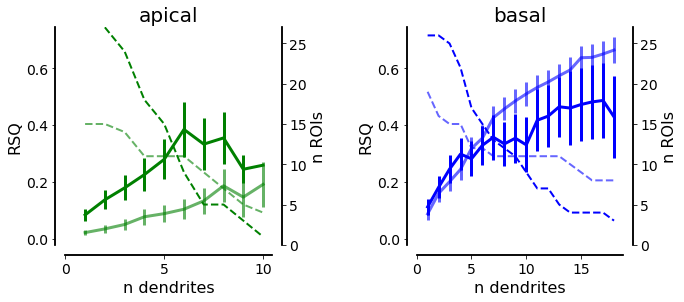

In [23]:
#3G. Commented code shows where to save data out for ANOVA with statsmodels
#only plots out to n_dendrites that existed for both WT and KO within-dendrite type
#all dendrites belong to place cells
filePath = os.path.join(dataDir, 'single_cell', 'somaPredictTCs_activeOnly_pcsOnly.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
maxN = np.max(df.n_dend.unique())
error = {}
fig, axes = plt.subplots(1, len(dendTypes), figsize=(10, 4), sharey=True)
plt.subplots_adjust(wspace=.7)

for dendType, color, ax in zip(dendTypes, dendColors, axes):
    maxInds = []
    for group in groups:
        currDF = filterDF(df, {'group':group, 'type':dendType}, resetIndex=True)
        error[group] = np.empty((currDF.shape[0], maxN))
        error[group].fill(np.nan)
        for idx, cell in currDF.iterrows():
            currErr = cell['RSQs']
            error[group][idx, :len(currErr)] = currErr    
        maxInds.append(np.argmax([np.all(np.isnan(error[group][:, idx])) for idx in np.arange(maxN)]))
    lastInd = np.min(maxInds[maxInds != 0])

#     for group in groups:
#         saveData(np.transpose(error[group][:, :lastInd]), 'tuningCurveGLM_{}_{}'.format(dendType, group), 'simple')
    
    ax2 = ax.twinx()
    for group, alphaVal in zip(groups, alphaVals):
        rgba = (color[0], color[1], color[2], alphaVal)
        meanVals = np.nanmean(error[group], axis=0)
        sem = stats.sem(error[group], axis=0, nan_policy='omit')
        Ns = np.sum(~np.isnan(error[group]), axis=0)
        ax.errorbar(np.arange(lastInd) + 1, meanVals[:lastInd], yerr=sem[:lastInd], color=rgba, lw=3)
        ax2.plot(np.arange(lastInd) + 1, Ns[:lastInd], color=rgba, lw=2, ls='--')

    ax.set_title(dendType, fontsize=20)
    ax.set_ylabel('RSQ', fontsize=16)
    ax2.set_ylabel('n ROIs', fontsize=16)
    ax2.set_ylim([0, 27])
    ax.set_xlabel('n dendrites', fontsize=16)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.set_xlim([0, ax.get_xlim()[1]])
    formatPlot(ax, left=False, bottom=False, right=False, top=True)
    formatPlot(ax2, left=False, bottom=False, right=False, top=True)

del df

# Figure 4

apical: WT mean = 1.40034698401 +/- 0.0987950793913, n = 170; KO mean = 0.750305481497 +/- 0.143892065693, n = 113; ttest t = 3.72424020241, p = 0.000251319510277
basal: WT mean = 0.835696161569 +/- 0.16216075117, n = 83; KO mean = 1.10731234362 +/- 0.114560893705, n = 149; ttest t = -1.36803004627, p = 0.173198055704


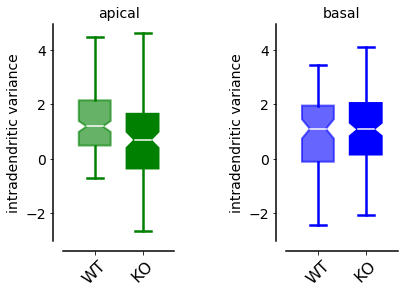

In [24]:
#4B
filePath = os.path.join(dataDir, 'single_cell', 'dendHotSpots_activeOnly_spikes.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
plt.subplots_adjust(wspace=1, hspace=1)

for ax, color, dendType in zip(axes, dendColors, dendTypes):
    cv = {}
    rgb = to_rgb(color)
    positions = []
    x = .5
    for group, alphaVal in zip(groups, alphaVals):
        dendDF = filterDF(df, {'group':group, 'dendType':dendType})
        currVals = np.log2(dendDF.cv / dendDF.cv_static)
        cv[group] = currVals
        positions.append(x)
        x += .75
        
    bp = ax.boxplot(cv.values(), positions=positions, labels=groups, showfliers=False, widths=0.5, 
                   patch_artist=True, notch=True)
    for box, alphaVal in zip(bp['boxes'], alphaVals):
            rgba = (rgb[0], rgb[1], rgb[2], alphaVal)
            box.set(color=rgba, lw=2)
    for box in bp['medians']:
        box.set(color='w', lw=1.5)
    for element in ['whiskers', 'caps']:
        for box in bp[element]:
            box.set(color=rgba, lw=2.5)

    ax.set_title(dendType, fontsize=14)
    ax.set_ylabel('intradendritic variance', fontsize=14)
    ax.yaxis.set_tick_params(labelleft=True)
    formatPlot(ax)
    ax.set_xticklabels(groups, fontsize=16, rotation=45)
    
    print('{}: {}'.format(dendType, printResults(cv)))

del df

apical: WT mean = 0.378385812702 +/- 0.0111616931544, n = 152; KO mean = 0.468774120537 +/- 0.0162069883248, n = 111; ttest t = -4.59321335312, p = 7.6049345532e-06
basal: WT mean = 0.510346937128 +/- 0.0206028443704, n = 76; KO mean = 0.474253401656 +/- 0.0118785565583, n = 139; ttest t = 1.5176912793, p = 0.131605169571


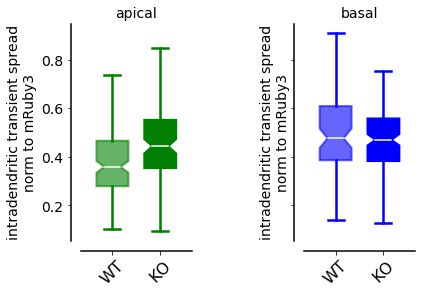

In [25]:
#4D
filePath = os.path.join(dataDir, 'single_cell', 'dendTransientSpread_activeOnly_isolated.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)
plt.subplots_adjust(wspace=1)

for ax, color, dendType in zip(axes, dendColors, dendTypes):
    cv = {}
    rgb = to_rgb(color)
    positions = []
    x = .5
    for group, alphaVal in zip(groups, alphaVals):
        currVals = filterDF(df, {'group':group, 'dendType':dendType}).transSpread
        cv[group] = currVals[~np.isnan(currVals)]
        positions.append(x)
        x += .75
        
    bp = ax.boxplot(cv.values(), positions=positions, labels=groups, showfliers=False, widths=0.5, 
                   patch_artist=True, notch=True)
    for box, alphaVal in zip(bp['boxes'], alphaVals):
            rgba = (rgb[0], rgb[1], rgb[2], alphaVal)
            box.set(color=rgba, lw=2)
    for box in bp['medians']:
        box.set(color='w', lw=1.5)
    for element in ['whiskers', 'caps']:
        for box in bp[element]:
            box.set(color=rgba, lw=2.5)

    formatPlot(ax)
    ax.set_title(dendType, fontsize=14)
    ax.set_xticklabels(groups, fontsize=16, rotation=45)
    ax.set_ylabel('intradendritic transient spread\nnorm to mRuby3', fontsize=14)
    
    print('{}: {}'.format(dendType, printResults(cv)))
    
del df

apical WT: r = -0.181714974259, p = 1.31932260365e-09, n =110
apical KO: r = -0.0619954577064, p = 0.0730318238452, n =100
apical: WT med = 0.130176798738, IQR = 0.171330864471, n = 1098; KO med = 0.232365613892, IQR = 0.259561960133, n = 837; mann whitney U = 291394.0, p = 1.16131474466e-43
basal WT: r = -0.183457393079, p = 2.91466256269e-10, n =223
basal KO: r = -0.111547118536, p = 4.93961542956e-05, n =184
basal: WT med = 0.203708927647, IQR = 0.185716519606, n = 1163; KO med = 0.241387367893, IQR = 0.196647749559, n = 1318; mann whitney U = 670212.0, p = 3.27618353841e-08


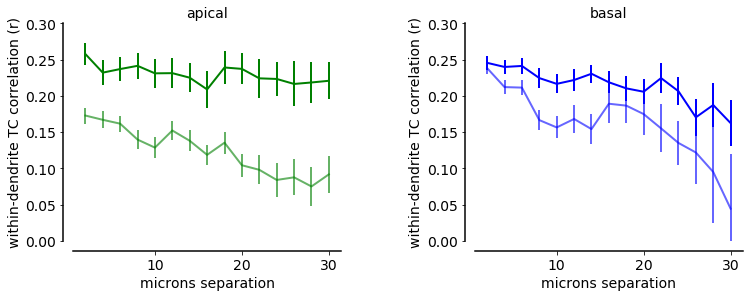

In [26]:
#4F. Commented code shows where to export data for ANOVA
filePath = os.path.join(dataDir, 'single_cell', 'dendSubCorrs_activeOnly_tc_spikes_pcsOnly.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
micronsPerROI = 2
maxDist = 30

fig, axes = plt.subplots(1, len(dendTypes), figsize=(12, 4), sharey=True)
plt.subplots_adjust(wspace=0.5)
for ax, dendType, color in zip(axes, dendTypes, dendColors):
    groupVals = {}
    for group, alphaVal in zip(groups, alphaVals):
        
        corrs = filterDF(df, {'group':group, 'dendType':dendType}).corrsByDistance
        maxN = np.max([len(x) for x in corrs])
        corrMat = np.empty((len(corrs), maxN))
        corrMat.fill(np.nan)
        for i, c in enumerate(corrs):
            corrMat[i, :len(c)] = c
            
        meanCorrs = np.nanmean(corrMat, axis=0)
        sem = stats.sem(corrMat, axis=0, nan_policy='omit')
        dists = np.arange(1, maxN + 1) * micronsPerROI
        maxInd = np.argmax(dists >= maxDist) + 1
        
        ax.errorbar(dists[:maxInd], meanCorrs[:maxInd], yerr=sem[:maxInd], color=color, alpha=alphaVal, 
                   lw=2, elinewidth=2)
        
        xVals = np.squeeze(np.tile(dists[:maxInd], (1, corrMat.shape[0])))
        yVals = corrMat[:, :maxInd].flatten()
        badInds = np.isnan(yVals)
        r, p = stats.spearmanr(xVals[~badInds], yVals[~badInds])
        groupVals[group] = yVals[~badInds]
        
        print('{} {}: r = {}, p = {}, n ={}'.format(dendType, group, r, p, len(corrs)))
#         saveData(np.transpose(corrMat[:, :maxInd]), 'dendSubCorrs_{}_{}'.format(dendType, group), 'simple')
    print('{}: {}'.format(dendType, printResults(groupVals)))
    ax.set_ylim([0, .3])
    ax.set_xlabel('microns separation', fontsize=14)
    ax.set_ylabel('within-dendrite TC correlation (r)', fontsize=14)
    ax.set_title(dendType, fontsize=14)
    formatPlot(ax)   
ax.yaxis.set_tick_params(labelleft=True)
    
del df

# Figure 5

WT mean = 0.0597126970878 +/- 0.016821290708, n = 25; KO mean = 0.128150267513 +/- 0.018304394366, n = 32; ttest t = -2.75294795328, p = 0.00799061233801


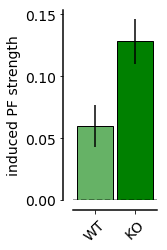

In [27]:
#5D
#quantification of mean dendrite histograms. set dend dtype in line below
label = 'apical' #from ['apical', 'basal']
filePath = os.path.join(dataDir, 'single_cell', 'normHists_{}_df_inducedOnly.pkl'.format(label))

with open(filePath, 'rb') as f:
    histDF = pkl.load(f)

color = typeColors[label]
bounds = [-0.075, 0.075]
nBins = len(histDF.iloc[0].normHist)
onset = nBins / 2 - 1
keepInds = np.arange(int(np.floor(nBins * bounds[0])), int(np.ceil(nBins * bounds[1] + 1))) + onset
  
fig, ax = plt.subplots(1, 1, figsize=(1.5, 3.5))
x = 1
vals = {}
for alphaVal, group in zip(alphaVals, groups):
    rgba = (color[0], color[1], color[2], alphaVal)
    baselineDF = filterDF(histDF, {'group':group, 'day':0, 'cond':'baseline'})    
    postDF = filterDF(histDF, {'group':group, 'day':0, 'cond':'post_norm'})
    currVals = []
    for cellDex, cell in postDF.iterrows():
        pre = filterDF(baselineDF, {'roiID':cell.roiID, 'roiLabel':cell.roiLabel}).normHist[0][keepInds]
        post = cell.normHist[keepInds]
        normHist = post - pre
        response = np.nanmax(normHist)
        currVals.append(response)
    vals[group] = currVals
    ax.bar(x, np.nanmean(currVals), yerr=stats.sem(currVals, nan_policy='omit'), 
           width=0.45, edgecolor='k', color=rgba, label=group)
    x += .5

ax.axhline(0, color='k', ls='--', alpha=0.5)
ax.set_xticks([1, 1.5])
ax.set_ylabel('induced PF strength', fontsize=14)
formatPlot(ax)
ax.set_xticklabels(groups, fontsize=14, rotation=45)

print(printResults(vals))

day 0: WT mean = 0.290074313296 +/- 0.0819171380001, n = 9; KO mean = 0.424093353676 +/- 0.0509877503759, n = 9; ttest t = -1.38895360935, p = 0.187516642951
day 1: WT mean = 0.0645213681782 +/- 0.0355788230739, n = 9; KO mean = 0.250655238913 +/- 0.0654295209489, n = 9; ttest t = -2.49920122237, p = 0.0274642541751
day 2: WT mean = 0.0759323084731 +/- 0.0225288610386, n = 9; KO mean = 0.230144008226 +/- 0.0324575805874, n = 9; ttest t = -3.90310051439, p = 0.00154227329999
day 3: WT mean = 0.0683488832098 +/- 0.0736781474996, n = 7; KO mean = 0.153617193379 +/- 0.0559928002231, n = 9; ttest t = -0.921420498567, p = 0.375067878691


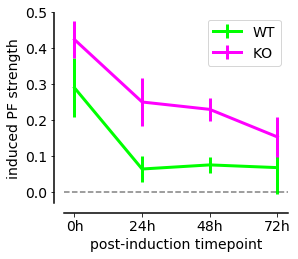

In [28]:
#5E. quantification of mean soma histograms
#Commented code shows where to export data by cell for ANOVA
filePath = os.path.join(dataDir, 'single_cell', 'normHists_soma_df_inducedOnly.pkl')

with open(filePath, 'rb') as f:
    histDF = pkl.load(f)

currDays = [0, 1, 2, 3]
bounds = [-0.075, 0.075]

nBins = len(histDF.iloc[0].normHist)
onset = nBins / 2 - 1
keepInds = np.arange(int(np.floor(nBins * bounds[0])), int(np.ceil(nBins * bounds[1] + 1))) + onset
  
fig, ax = plt.subplots(1, 1, figsize=(4,3.5))
mainLines = []
vals = [{} for day in days]
for color, group in zip(colors, groups):
    baselineDF = filterDF(histDF, {'group':group, 'day':0, 'cond':'baseline'})
    cellMeans = []
    cellVals = {}
    for day in currDays:
        currDF = filterDF(
            histDF, {'group':group, 'day':day, 'cond':'post_norm'})
        currVals = []
        for cell in currDF.itertuples():
            if day == 0:
                cellVals[cell.roiID] = []
            baselineHist = filterDF(baselineDF, {'roiID':cell.roiID})['normHist'].to_numpy()[0]
            normHist = cell.normHist[keepInds] - baselineHist[keepInds]
            response = np.nanmax(normHist)

            currVals.append(response)
            cellVals[cell.roiID].append(response)
    
        cellMeans.append(currVals) #list lists (N days, N cells)
        vals[day][group] = currVals
    meanVals = [np.nanmean(x) for x in cellMeans]
    error = [stats.sem(x, nan_policy='omit') for x in cellMeans]
    mainLines.append(ax.errorbar(currDays, meanVals, yerr=error, color=color, lw=3))
    
#     anovaData = np.ndarray((len(days), len(cellVals.keys())))
#     anovaData.fill(np.nan)
#     for idx, curve in enumerate(cellVals.values()):
#         anovaData[:len(curve), idx] = curve
#     saveData(anovaData, 'inductionHist_ANOVA_{}'.format(group), 'simple')
        
for day in days:
    print('day {}: {}'.format(day, printResults(vals[day])))

ax.axhline(0, color='k', ls='--', alpha=0.5)
ax.set_xticks(days)
ax.set_xticklabels(timepoints[2:])
ax.set_xlabel('post-induction timepoint', fontsize=14)
ax.set_ylabel('induced PF strength', fontsize=14)
ax.legend(mainLines, groups, fontsize=14)
formatPlot(ax)

# Fig 6

In [29]:
#this will overwrite variables for figs 2-5, so rerun at top if you go back to them
mouseNames = ['jo1096', 'jo1097', 'jo1099', 'jo2342', 'jo2344', 'jo2352']
labels = ['soma_green', 'soma_red'] #soma_green corresponds to WT, soma_red == KO
colors = [(0, 1, 0), (1, 0, 1)]
days = [0, 1, 2, 3, 4]

soma_green day 0: 154 events from 884 PCs
soma_green day 1: 59 events from 699 PCs
soma_green day 2: 79 events from 695 PCs
soma_green day 3: 49 events from 674 PCs
soma_green day 4: 25 events from 792 PCs
soma_red day 0: 147 events from 925 PCs
soma_red day 1: 68 events from 769 PCs
soma_red day 2: 50 events from 737 PCs
soma_red day 3: 78 events from 789 PCs
soma_red day 4: 30 events from 852 PCs


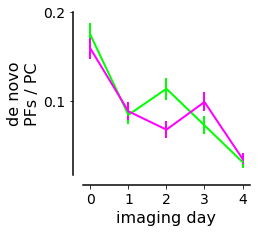

In [31]:
#6E
filePath = os.path.join(dataDir, 'population', 'isPF.pkl')
with open(filePath, 'rb') as f:
    isPF = pkl.load(f)
    
filePath = os.path.join(dataDir, 'population', 'pfFmtnKernel_minLap_10.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)

legendText = []
fig, ax = plt.subplots(figsize=(3, 3))
# dataList = []
for color, label in zip(colors, labels):
    legendText.append(label)
    isDeNovo = []
    for day in df.day.unique():
        currEvents = filterDF(filterDF(df, {'day':day, 'label':label}, resetIndex=False), 
                                 {'fmtnLap':np.nan}, inv=True, resetIndex=False)
        currData = np.zeros(np.sum(isPF[label][day]).astype('int'))
        currData[:currEvents.shape[0]] = 1
        isDeNovo.append(currData)
        print('{} day {}: {} events from {} PCs'.format(label, day, np.sum(currData).astype('int'), len(currData)))
#         for val in currData: #building dataframe to use for ANOVA in other notebook
#             dataList.append({'label':label, 'day':day, 'isDeNovo':val})

    rates = np.array([np.mean(d) for d in isDeNovo])
    errors = np.array([stats.sem(d) for d in isDeNovo])
    ax.errorbar(np.arange(len(rates)), rates, errors, c=color, lw=2)

ax.set_ylabel('de novo\nPFs / PC', fontsize=16)
ax.set_xlabel('imaging day', fontsize=16)
ax.set_xticks(np.arange(len(days)))
ax.set_yticks([.1, .2])
formatPlot(ax)
# anovaDF = pd.DataFrame(dataList)
# helpers.pickleData(anovaDF, 'RF', 'deNovoAcrossDays_ANOVA')
# del dataList, anovaDF
del df, isPF

soma_green Ns: [333, 285, 208, 150]
soma_red Ns: [341, 263, 214, 146]
1 day elapsed: soma_red med = 0.255902262673, IQR = 0.837598674517, n = 341; soma_green med = 0.0955074669973, IQR = 0.773624972444, n = 333; mann whitney U = 50843.0, p = 0.00944881533023
2 day elapsed: soma_red med = 0.134953471383, IQR = 0.790960820305, n = 263; soma_green med = 5.17309079011e-06, IQR = 0.723176636373, n = 284; mann whitney U = 33898.0, p = 0.0309738348445
3 day elapsed: soma_red mean = 0.211978930046 +/- 0.030808661601, n = 214; soma_green mean = 0.0565698944478 +/- 0.0312337335599, n = 208; ttest t = 3.54235852986, p = 0.000441062931242
4 day elapsed: soma_red mean = 0.163118597647 +/- 0.0361152784337, n = 146; soma_green mean = 0.028706032566 +/- 0.0366706938423, n = 150; ttest t = 2.61152709038, p = 0.00947654406649


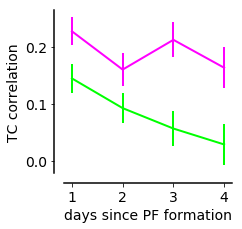

In [32]:
#6F
#Tuning curve correlations by lag for de novo PFs
filePath = os.path.join(dataDir, 'population', 'tcCorrs_deNovo_incMulti.pkl')
with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
lagVals = df.lag.unique()
fig, ax = plt.subplots(figsize=(3, 3))
for label, color in zip(labels, colors):
    meanVals = []
    errors = []
    meanVals_shuffled = []
    errors_shuffled = []
    Ns = []
    for lag in lagVals:
        currVals = filterDF(df, {'label':label, 'lag':lag})['corr']
        meanVals.append(np.nanmean(currVals))
        errors.append(stats.sem(currVals, nan_policy='omit'))
        Ns.append(len(currVals))
    ax.errorbar(days[1:], meanVals, errors, linewidth=2, color=color)
    print('{} Ns: {}'.format(label, Ns))
formatPlot(ax)
ax.set_xticks(days[1:])
ax.set_xlabel('days since PF formation', fontsize=14)
ax.set_ylabel('TC correlation', fontsize=14)

for lag in lagVals:
    lagData = {}
    for label in labels:
        currVals = filterDF(df, {'label':label, 'lag':lag})['corr']
        lagData[label] = currVals[np.isfinite(currVals)]
    print('{} day elapsed: {}'.format(lag, printResults(lagData)))
del df

soma_green: 350 tcs
soma_red: 369 tcs


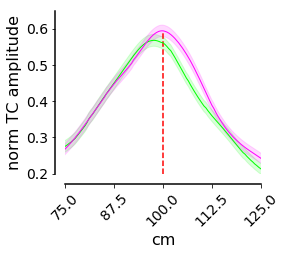

In [33]:
#6G. This analysis uses a high number of spatial bins (400 over 2 m) to precisely localize
#peak activity assoc'd with PF formation. The loaded file is large - make sure to clear.
filePath = os.path.join(dataDir, 'population', 'heatmapsAlignedToFmtn_spikeCenter.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
fig, ax = plt.subplots(figsize=(3.5, 3))

for color, label in zip(colors, labels):
    currDF = filterDF(df, {'label':label})
    tcs = []
    fmtnLaps = []
    for _, event in currDF.iterrows():
        currMap = event.heatmap_aligned_smoothed[int(event.fmtnLap) + 1:, :]
        tcs.append(np.nanmean(currMap, axis=0))
        
    print('{}: {} tcs'.format(label, len(tcs)))
    tcs = [tc - np.nanmin(tc) for tc in tcs]
    tcs = np.vstack([tc / np.nanmax(tc) for tc in tcs])

    meanTC = np.nanmean(tcs, axis=0)
    yerr = stats.sem(tcs, axis=0)
    ax.plot(meanTC, color=color, lw=1)
    ax.fill_between(np.arange(tcs.shape[1]), meanTC - yerr, meanTC + yerr, color=color, alpha=0.15)
    
ax.set_xlim([150, 250])
ax.vlines(tcs.shape[1] / 2, .2, np.max(meanTC), color='r', linestyle='--')
ax.set_ylim([.2, .65])
ax.set_ylabel('norm TC amplitude', fontsize=16)

formatPlot(ax)
ax.set_xticklabels([str(t*.5) for t in ax.get_xticks()], fontsize=14, rotation=45)
ax.set_xlabel('cm', fontsize=16)

del df, currDF

soma_red med = -1.0, IQR = 20.0, n = 369; soma_green med = -4.0, IQR = 21.875, n = 350; mann whitney U = 57562.5, p = 0.00588286830338


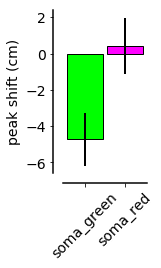

In [34]:
#6H, right. This analysis uses a high number of spatial bins (400 over 2 m) to precisely localize
#peak activity assoc'd with PF formation. The loaded file is large - make sure to clear.
filePath = os.path.join(dataDir, 'population', 'heatmapsAlignedToFmtn_spikeCenter.pkl')

with open(filePath, 'rb') as f:
    df = pkl.load(f)
    
trackLength = 200. #cm
    
fig, ax = plt.subplots(figsize=(1.5, 3))

groupVals = {}
tickLocs = []
x = 0
for color, label in zip(colors, labels):
    currDF = filterDF(df, {'label':label})
    dists = []
    for _, event in currDF.iterrows():
        currMap = event.heatmap_aligned_smoothed[int(event.fmtnLap) + 1:, :]            
        postPeak = np.nanargmax(np.nanmean(currMap, axis=0))
        shift_bins = postPeak - event.fmtnBin
        shift_dist = shift_bins * (trackLength / currMap.shape[1])
        dists.append(shift_dist)
        
    ax.bar(x, np.nanmean(dists), yerr=stats.sem(dists, nan_policy='omit'), 
           color=color, edgecolor='k', lw=1, width=0.45, error_kw={'lw':2})
    tickLocs.append(x)
    x += .5
    groupVals[label] = dists

print(printResults(groupVals))
formatPlot(ax)
ax.set_ylabel('peak shift (cm)', fontsize=14)
ax.set_xticks(tickLocs)
ax.set_xticklabels(labels, rotation=45, fontsize=14)

del df, currDF

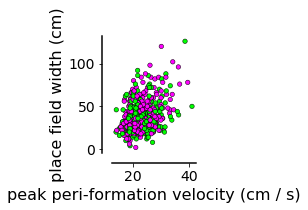

In [35]:
#6I, left
filePath = os.path.join(dataDir, 'population', 'pfFmtnKernel_minLap_10.pkl')

with open(filePath, 'rb') as f:
    data = pkl.load(f)

velString = 'velocity_pfPeak'
varString = 'pfWidth'
fig, ax = plt.subplots(figsize=(1.5,2.15))

keepInds = np.where(~np.isnan(data[varString]))[0]
data = data.iloc[keepInds]
shuffleInds = np.random.permutation(len(data)) #plot points interleaved
data = data.iloc[shuffleInds]
currColors = [colors[np.argmax([pf.label == l for l in labels])] 
              for _, pf in data.iterrows()]
ax.scatter(data[velString], data[varString], s=20, c=currColors, 
           edgecolor='k', lw=0.5)

ax.set_xlabel('peak peri-formation velocity (cm / s)', fontsize=16)
ax.set_ylabel('place field width (cm)', fontsize=16)
formatPlot(ax)
    
del data

r = 0.327257682988, m = 1.19199947971, p = 1.39040444332e-10, n = 366
r = 0.413865566071, m = 1.73546450782, p = 7.22490100798e-17, n = 373


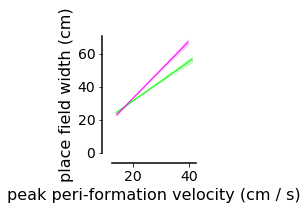

In [36]:
#6I, right
filePath = os.path.join(dataDir, 'population', 'pfFmtnKernel_minLap_10.pkl')

with open(filePath, 'rb') as f:
    data = pkl.load(f)

velString = 'velocity_pfPeak'
varString = 'pfWidth'
fig, ax = plt.subplots(figsize=(1.5,2.15))

for label, color in zip(labels, colors):
    currDF = filterDF(data, {'label':label})
    keepInds = np.where(~np.isnan(currDF[velString]))[0]
    xData = currDF.iloc[keepInds][velString].to_numpy()
    sortInds = np.argsort(xData)
    yData = currDF.iloc[keepInds][varString].to_numpy()[sortInds]
    xData = xData[sortInds]
    
    #calc fits
    n = len(xData)
    m, b, r, p, _ = stats.linregress(xData, yData)
    print('r = {}, m = {}, p = {}, n = {}'.format(r, m, p, n))
    coeffs = np.polyfit(xData, yData, deg=1)
    lm = np.poly1d(coeffs)
    yfit = lm(xData)
    resid = yData - yfit
    
    #calc confidence intervals
    testX = np.linspace(np.min(xData), np.max(xData), 100)
    meanX = np.mean(xData)
    tVal = stats.t.ppf(1 - .05 / 2, n - 2)
    ss = np.sum(np.power(resid, 2))
    confs = tVal * np.sqrt((ss / n - 2)) * (1.0 / n + (np.power((testX - meanX), 2) /\
                        ((np.sum(np.power(xData, 2))) - n * (np.power(meanX, 2)))))
    testFit = lm(testX)
    lower = testFit - abs(confs)
    upper = testFit + abs(confs)

    ax.plot([xData[0], xData[-1]], [yfit[0], yfit[-1]], color=color, lw=1, alpha=1)
    ax.fill_between(testX, lower, upper, color=color, alpha=0.2)

ax.set_xlabel('peak peri-formation velocity (cm / s)', fontsize=16)
ax.set_ylabel('place field width (cm)', fontsize=16)
ax.set_ylim([0, ax.get_ylim()[1]])
formatPlot(ax)
    
del data, currDF

soma_green: 34.2240437158 +/- 0.769358681638; N = 366
soma_red: 37.5227882038 +/- 0.874555092947; N = 373
soma_red med = 32.0, IQR = 20.0, n = 373; soma_green med = 32.0, IQR = 16.0, n = 366; mann whitney U = 60669.0, p = 0.00443894616704


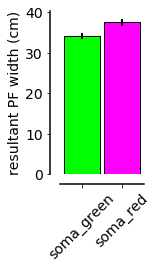

In [37]:
#6J
filePath = os.path.join(dataDir, 'population', 'pfFmtnKernel_minLap_10.pkl')
with open(filePath, 'rb') as f:
    data = pkl.load(f)
    
dataLabel = 'pfWidth'

fig, ax = plt.subplots(figsize=(1.5,3))
tickLabels = []
tickLocs = []
ct = 0
currData = {}
for color, label in zip(colors, labels):
    currData[label] = filterDF(data, {'label':label})[dataLabel]
    meanVal = np.mean(currData[label])
    error = stats.sem(currData[label])
    tickLabels.append(label)
    ax.bar(ct, meanVal, yerr=error, color=color, edgecolor='k', 
           lw=1, width=0.45, error_kw={'lw':2})
    print('{}: {} +/- {}; N = {}'.format(label, meanVal, error, currData[label].shape[0]))
    tickLocs.append(ct)
    ct += .5
        
print(printResults(currData))

ax.set_ylabel('resultant PF width (cm)', fontsize=14)
formatPlot(ax)
ax.set_xticks(tickLocs)
ax.set_xticklabels(tickLabels, rotation=45, fontsize=14)

del data, currData